<a href="https://colab.research.google.com/github/AnnaLinton/SciML-SeaIce/blob/main/SeaIceNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from IPython.display import Image
Image(url='https://i.imgur.com/DeB62Nl.png', width=500)

<div style="background-color: #ccffcc; padding: 10px;">

# This is the Leeds SciML Hackathon Tutorial Notebook.    
    
This notebook covers:
    
* How to download/access the Hackathon data
* Installing python environment (if applicable)
* Exploring the data set
* Example U-Net model and training
* Using [Weights & Biases and connecting with SciMl community](https://wandb.ai/sciml-leeds)
* Plotting metrics
* Evaluating the model Submitting Results     
    
*please ensure the suitable notebook is chosen for running on [remote/home machine](Introduction_own_notebook_server.ipynb), **GoogleCoLab** or [Jupyter99](Introduction_JupyterHub99.ipynb))*     
    
## Useful Links

* [Kaggle Competition Page](https://www.kaggle.com/competitions/leeds-sciml-sea-ice-segmentation)
* [Weights & Biases SciML Leeds team](https://wandb.ai/sciml-leeds)
    
</div>

In [ ]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/U4amljFGkiw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<div style="background-color: #ccffcc; padding: 10px;">
    
# Setup

First, let's set up the environment by installing the required libraries and importing the necessary modules.
    
</div>

<div style="background-color: #ccffcc; padding: 10px;">

* Create a Kaggle account: If you don't already have a Kaggle account, go to the Kaggle website (https://www.kaggle.com/) and sign up for an account.

* Generate the kaggle.json file: After logging in to Kaggle, go to your account settings page. Scroll down to the section titled "API" and click on the "Create New API Token" button. This will download a file named kaggle.json to your computer.

* Upload kaggle.json to the runtime environment. Use the file upload below.
    
</div>    

In [ ]:
#@title
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    if fn != 'kaggle.json': print('Are you sure you\'ve uploaded the right file?')
    print(f'Uploaded file "{fn}"')

Saving kaggle.json to kaggle.json
Uploaded file "kaggle.json"


In [ ]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d spiruel/leeds-sciml-seaice

100% 2.98G/2.99G [00:19<00:00, 157MB/s]
100% 2.99G/2.99G [00:19<00:00, 162MB/s]


In [ ]:
!unzip leeds-sciml-seaice.zip

<div style="background-color: #ccffcc; padding: 10px;">

# 🚀 Installing and importing
    
</div>    

In [ ]:
#import all the necessary libraries for this notebook

#weights and biases
!pip install wandb --quiet
import wandb
from wandb.keras import WandbCallback

#maths and plotting
import numpy as np
import matplotlib.pyplot as plt

#machine learning
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.optimizers import adam, Adadelta
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

#file system
import os, glob
import tifffile
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
from skimage.transform import resize

<div style="background-color: #ccffcc; padding: 10px;">
    
The `patch_paths` variables are arrays containing the names of the patch files.
Each patch patch has a corresponding SAR image, multispectral image, and label. (Except we've not given you the labels for the test patch paths).

</div>

In [ ]:
DATA_DIR = 'sciml'
train_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/train/*_sar.tiff')])
test_patch_paths = np.array([os.path.basename(i[:-9]) for i in glob.glob(f'{DATA_DIR}/test/*_sar.tiff')])

#display patch paths
train_patch_paths

array(['Patch20190226_218_1320_960', 'Patch20190101_94_480_1080',
       'Patch20190101_139_720_1440', ..., 'Patch20190222_31_720_1440',
       'Patch20190205_153_840_1440', 'Patch20191216_276_1440_1320'],
      dtype='<U27')

In [ ]:
def resize_image_array(image_array, size):
    resized_array = resize(image_array, size, anti_aliasing=True)
    return resized_array


def downscale_local_mean_image_array(image_array, size):
    resized_array = downscale_local_mean(image_array, size)
    return resized_array

In [ ]:
#@title We use a data generator generates batches of data on-the-fly, reducing the memory requirements and enabling training on large datasets that may not fit entirely into memory.

from tensorflow.keras.utils import Sequence

def load_img(path):
    img = tifffile.imread(path)
    return img

class DataGenerator(Sequence):
    def __init__(self, patch_paths, data_dir, batch_size, split='train'):
        self.patch_paths = patch_paths
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.split = split

    def __len__(self):
        return len(self.patch_paths) // self.batch_size

    def __getitem__(self, index):
        batch_paths = self.patch_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X_sar, X_ms, y = [], [], []

        for patch_path in batch_paths:
            try:
                sar_path = os.path.join(self.data_dir, self.split, patch_path + '_sar.tiff')
                ms_path = os.path.join(self.data_dir, self.split, patch_path + '_vis.tiff')
                if self.split != 'test':
                  label_path = os.path.join(self.data_dir, self.split, patch_path + '_ref.tiff')
                  label_arr = load_img(label_path)
                  y.append(label_arr)

                sar_arr = load_img(sar_path)
                ms_arr = load_img(ms_path)

                sarr_resize = resize_image_array(sar_arr, (240,240))
                X_sar.append(sarr_resize)


                # X_sar.append(sar_arr)
                X_ms.append(ms_arr)

            except Exception as e:
                print(e)
                continue

        X_sar = np.expand_dims(np.array(X_sar), -1)#[:, ::3, ::3, :]
        X_ms = np.array(X_ms)
        if self.split != 'test':
          y = np.expand_dims(np.array(y), -1)
          return [X_sar, X_ms], y
        else:
          return [X_sar, X_ms], [None]*len(X_sar)

batch_size = 16

# Split data into train and test sets
train_patch_paths, val_patch_paths = train_test_split(train_patch_paths, test_size=0.2, random_state=42)
train_generator = DataGenerator(train_patch_paths, DATA_DIR, batch_size)
val_generator = DataGenerator(val_patch_paths, DATA_DIR, batch_size)
test_generator = DataGenerator(test_patch_paths, DATA_DIR, batch_size, split='test')

In [ ]:
def explore_dimensions(obj, level=0):
    if isinstance(obj, list) or isinstance(obj, tuple):
        print("Level:", level, "- List with length:", len(obj))
        for item in obj:
            explore_dimensions(item, level + 1)
    elif isinstance(obj, np.ndarray):
        print("Level:", level, "- Array shape:", obj.shape)


In [ ]:
explore_dimensions(train_generator[0])

<div style="background-color: #ccffcc; padding: 10px;">

The U-Net model architecture is a convolutional neural network that consists of an encoder and a decoder.
The encoder extracts features from the input images, while the decoder upsamples the features to generate the final segmentation map.

The model is compiled with the Adam optimiser and binary cross-entropy loss.
During training, the validation data is used to monitor the performance of the model and early stopping is applied to prevent overfitting.

The training progress can be logged using the wandb library, which allows tracking and visualisation of metrics in a web interface.
    
</div>

In [ ]:
def unet():
    # Input layers
    input_sar = Input((240, 240, 1))
    input_ms = Input((240, 240, 3))

    # Resizing input_sar
    # resized_ms = UpSampling2D(size=(3, 3))(input_ms)

    # Concatenate inputs
    concat = concatenate([input_sar, input_ms], axis=-1)

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoding path
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Output layers
    output = Conv2D(1, 1, activation = 'sigmoid')(conv7)
    output = UpSampling2D(size=(4, 4))(output)

    # Model
    model = Model(inputs=[input_sar, input_ms], outputs=output)

    return model

# Create model
model = unet()

In [ ]:
model.compile(optimizer=adam.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])

<div style="background-color: #ccffcc; padding: 10px;">
    

# ✅ Sign Up

Sign up to a free [Weights & Biases account here](https://wandb.ai/signup)

[Weights and Biases docs](https://docs.wandb.ai/quickstart)

if you have signed up for weights and biases then set `wandb_enabled = True`, if not then set to `False`
    
The cell below will train the model and capture some metrics
    
**If not part of the sciml-leeds group on weights and biases then remove**
    
```python
entity='sciml-leeds'
```
        
</div>    

In [ ]:
# Initialize a new W&B run
wandb_enabled = True

earlystopper = EarlyStopping(patience=5, verbose=1)
if wandb_enabled:
    wandb.init(entity='sciml-leeds', project='sea-ice-segmentation')
    history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          use_multiprocessing=True,
          workers=6,
          callbacks=[earlystopper, WandbCallback()])
    wandb.finish()
else:
    history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          use_multiprocessing=True,
          workers=6,
          callbacks=[earlystopper])

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
90/90 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8752 - mean_io_u: 0.2458

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 2.0s


90/90 [==============================] - 80s 590ms/step - loss: 0.3197 - accuracy: 0.8752 - mean_io_u: 0.2458 - val_loss: 0.2511 - val_accuracy: 0.8925 - val_mean_io_u: 0.2538
Epoch 2/15
90/90 [==============================] - 42s 457ms/step - loss: 0.2060 - accuracy: 0.9241 - mean_io_u: 0.2458 - val_loss: 0.2797 - val_accuracy: 0.8866 - val_mean_io_u: 0.2538
Epoch 3/15
90/90 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9282 - mean_io_u: 0.2458

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 1.7s


90/90 [==============================] - 57s 620ms/step - loss: 0.1970 - accuracy: 0.9282 - mean_io_u: 0.2458 - val_loss: 0.2269 - val_accuracy: 0.9072 - val_mean_io_u: 0.2538
Epoch 4/15
90/90 [==============================] - ETA: 0s - loss: 0.1729 - accuracy: 0.9361 - mean_io_u: 0.2464

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 2.0s


90/90 [==============================] - 54s 593ms/step - loss: 0.1729 - accuracy: 0.9361 - mean_io_u: 0.2464 - val_loss: 0.1930 - val_accuracy: 0.9265 - val_mean_io_u: 0.2538
Epoch 5/15
90/90 [==============================] - 44s 475ms/step - loss: 0.1631 - accuracy: 0.9419 - mean_io_u: 0.2459 - val_loss: 0.2025 - val_accuracy: 0.9246 - val_mean_io_u: 0.2538
Epoch 6/15
90/90 [==============================] - 40s 429ms/step - loss: 0.1645 - accuracy: 0.9381 - mean_io_u: 0.2498 - val_loss: 0.2157 - val_accuracy: 0.9068 - val_mean_io_u: 0.2538
Epoch 7/15
90/90 [==============================] - ETA: 0s - loss: 0.1705 - accuracy: 0.9302 - mean_io_u: 0.2464

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 3.9s


90/90 [==============================] - 55s 592ms/step - loss: 0.1705 - accuracy: 0.9302 - mean_io_u: 0.2464 - val_loss: 0.1681 - val_accuracy: 0.9322 - val_mean_io_u: 0.2538
Epoch 8/15
90/90 [==============================] - 40s 429ms/step - loss: 0.1483 - accuracy: 0.9454 - mean_io_u: 0.2487 - val_loss: 0.2108 - val_accuracy: 0.9232 - val_mean_io_u: 0.2551
Epoch 9/15
90/90 [==============================] - 44s 478ms/step - loss: 0.1472 - accuracy: 0.9445 - mean_io_u: 0.2459 - val_loss: 0.1687 - val_accuracy: 0.9315 - val_mean_io_u: 0.2538
Epoch 10/15
90/90 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9468 - mean_io_u: 0.2462

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 2.0s


90/90 [==============================] - 61s 664ms/step - loss: 0.1401 - accuracy: 0.9468 - mean_io_u: 0.2462 - val_loss: 0.1546 - val_accuracy: 0.9360 - val_mean_io_u: 0.2538
Epoch 11/15
90/90 [==============================] - 44s 477ms/step - loss: 0.1402 - accuracy: 0.9489 - mean_io_u: 0.2477 - val_loss: 0.1782 - val_accuracy: 0.9250 - val_mean_io_u: 0.2538
Epoch 12/15
90/90 [==============================] - 44s 468ms/step - loss: 0.1311 - accuracy: 0.9511 - mean_io_u: 0.2655 - val_loss: 0.1927 - val_accuracy: 0.9183 - val_mean_io_u: 0.2538
Epoch 13/15
90/90 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9502 - mean_io_u: 0.2465

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 1.8s


90/90 [==============================] - 55s 595ms/step - loss: 0.1486 - accuracy: 0.9502 - mean_io_u: 0.2465 - val_loss: 0.1530 - val_accuracy: 0.9425 - val_mean_io_u: 0.2552
Epoch 14/15
90/90 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9516 - mean_io_u: 0.2470

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 1.7s


90/90 [==============================] - 53s 575ms/step - loss: 0.1289 - accuracy: 0.9516 - mean_io_u: 0.2470 - val_loss: 0.1475 - val_accuracy: 0.9463 - val_mean_io_u: 0.2545
Epoch 15/15
90/90 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9562 - mean_io_u: 0.2501

wandb: Adding directory to artifact (/content/wandb/run-20230630_143307-cl10byvg/files/model-best)... Done. 1.6s


90/90 [==============================] - 56s 606ms/step - loss: 0.1198 - accuracy: 0.9562 - mean_io_u: 0.2501 - val_loss: 0.1438 - val_accuracy: 0.9450 - val_mean_io_u: 0.2538


accuracy,▁▅▆▆▇▆▆▇▇▇▇█▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▄▃▃▃▃▂▂▂▂▁▂▁▁
mean_io_u,▁▁▁▁▁▂▁▂▁▁▂█▁▁▃
val_accuracy,▂▁▃▆▅▃▆▅▆▇▅▅███
val_loss,▇█▅▄▄▅▂▄▂▂▃▄▁▁▁
val_mean_io_u,▁▁▁▁▁▁▁▇▁▁▁▁█▄▁
accuracy,0.95621
best_epoch,14
best_val_loss,0.14378
epoch,14


Text(0, 0.5, 'loss')

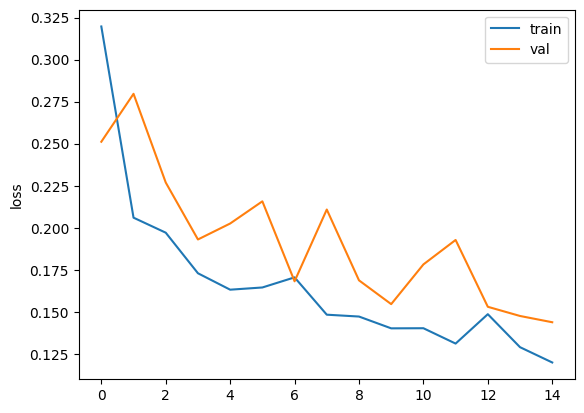

In [ ]:
#@title Now plot the results of the training run:

metric_to_plot = 'loss' #@param ['loss', 'accuracy', 'mean_io_u']

ys = history.history[metric_to_plot]
ys_val = history.history['val_'+metric_to_plot]
num_epochs = len(ys)
plt.plot(range(num_epochs), ys, label='train')
plt.plot(range(num_epochs), ys_val, label='val')
plt.legend()
plt.ylabel(metric_to_plot)

<div style="background-color: #ccffcc; padding: 10px;">

Let's dive into the visualization of our sea ice segmentation results using the validation dataset. By running the code snippet provided, we obtain valuable insights into the model's performance and its ability to accurately identify sea ice boundaries.

First, the model makes predictions on the validation dataset using the model.predict() function. The resulting predictions are stored in the variable preds. These predictions represent the segmentation masks, indicating the presence or absence of sea ice in the images.

Next, we extract a single batch of data from the validation generator using next(iter(val_generator)). This batch consists of SAR (Synthetic Aperture Radar) images, multispectral (MS) images, and their corresponding ground truth segmentation masks. These components are unpacked into the variables X_sar_test, X_ms_test, and y_test, respectively.

Now, we proceed to visualize the results. Within a loop, we iterate over the predictions stored in preds. For each prediction, we create a figure with a grid layout of four subplots.

The first subplot, labeled "SAR Image," displays the SAR image from the validation set. SAR imagery provides valuable information about the surface characteristics of sea ice.

The second subplot, labeled "MS Image," showcases the multispectral image captured during the validation process. Multispectral data enables us to analyze sea ice from different spectral perspectives.

Moving on to the third subplot, titled "Segmentation Mask," we observe the model's predicted segmentation mask. The thresholding operation (`preds[i,:,:,0]>threshold`) helps us visualize the predicted sea ice boundaries clearly.

Lastly, the fourth subplot, labeled "Ground Truth," presents the actual ground truth segmentation mask obtained from the validation dataset. This serves as a reference to assess the accuracy of our model's predictions.

By carefully examining these subplots, we can compare the model's predictions against the ground truth and gain insights into the performance and limitations of our sea ice segmentation model.

In [ ]:
#@markdown You need to specify the threshold value, which determines the threshold for classifying pixels as foreground or background. Adjusting this value may affect the performance of the segmentation.

threshold = 0.6 #@param {type:"slider", min:0, max:1, step:0.1}

1/1 [==============================] - 1s 1s/step


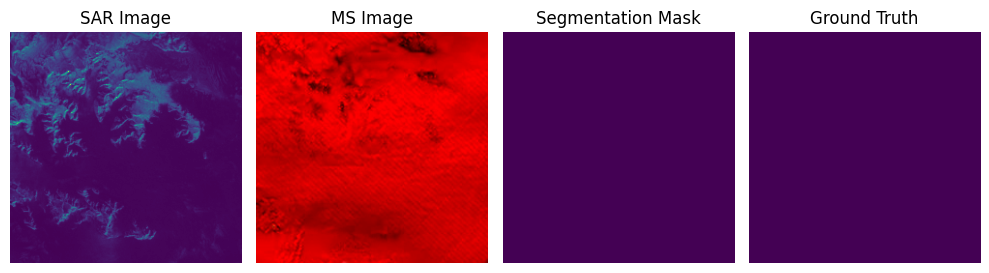

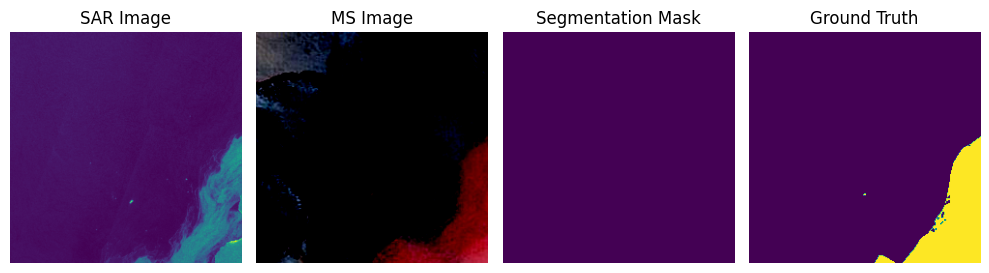

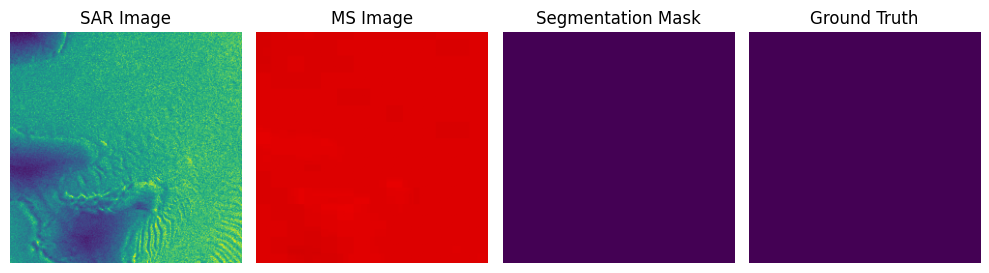

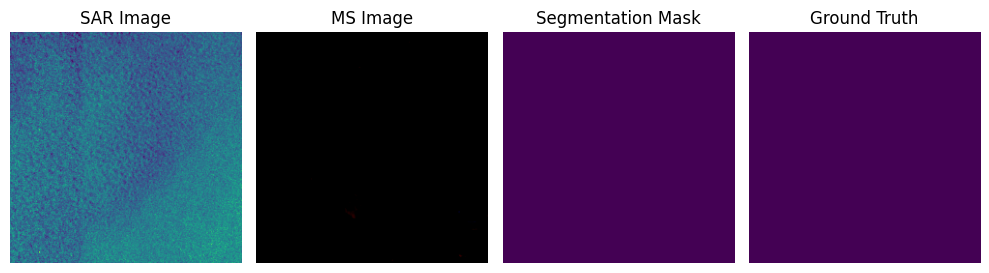

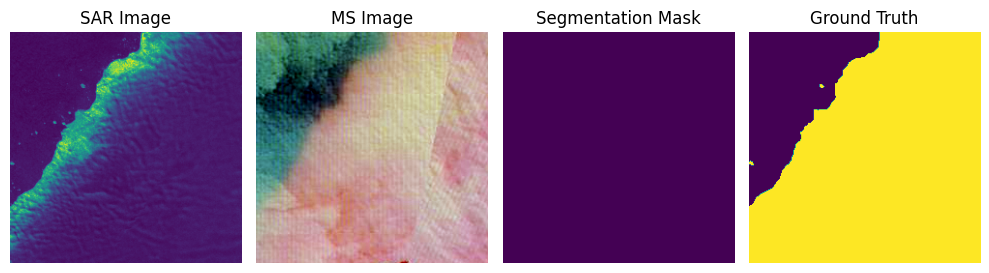

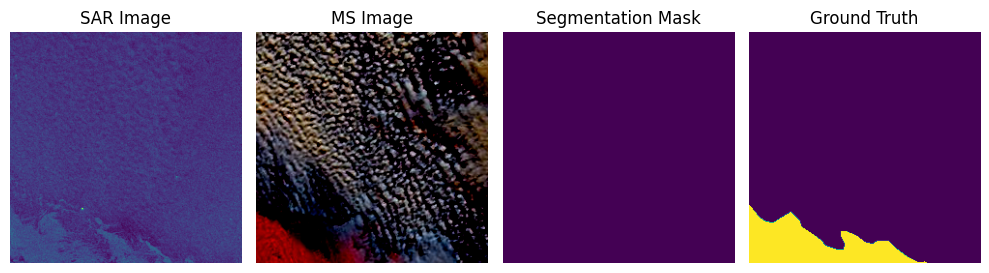

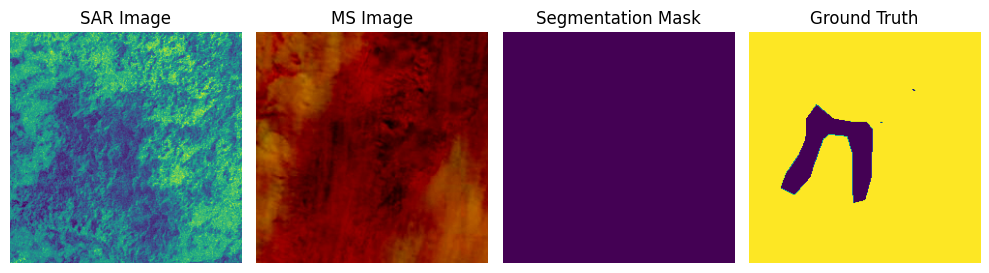

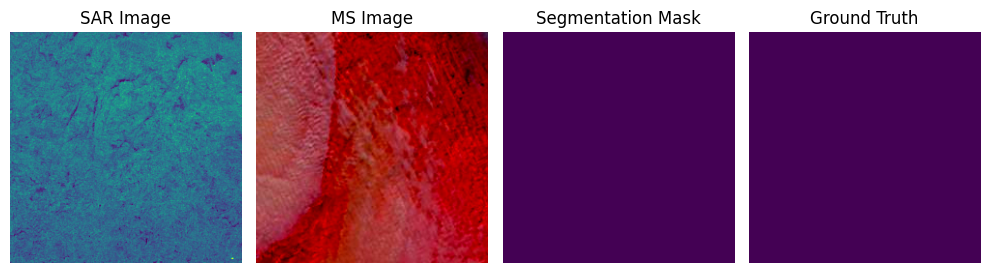

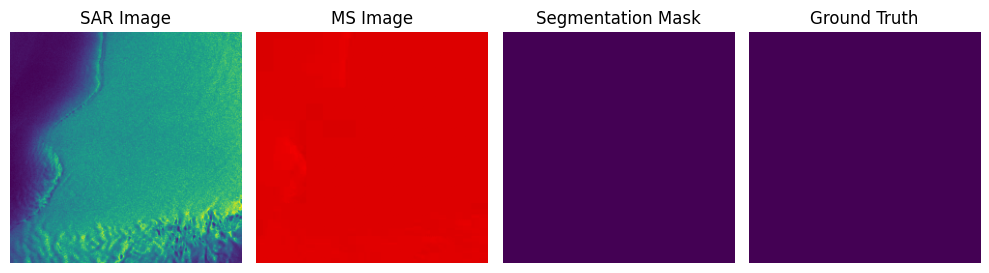

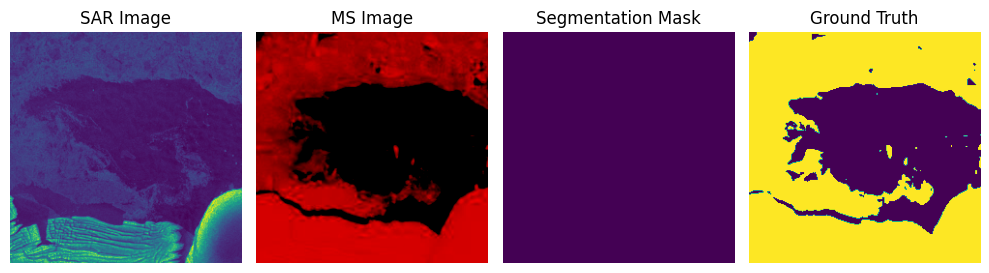

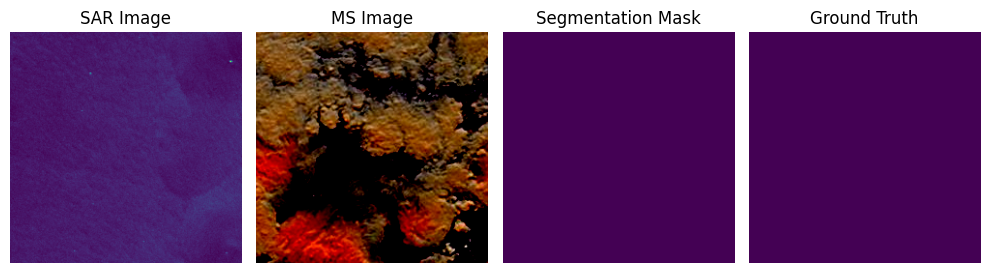

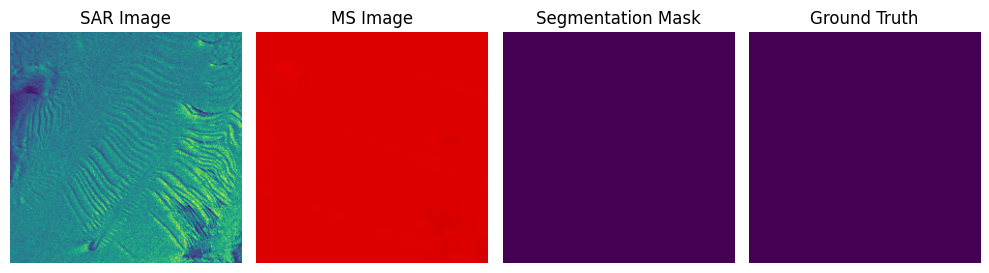

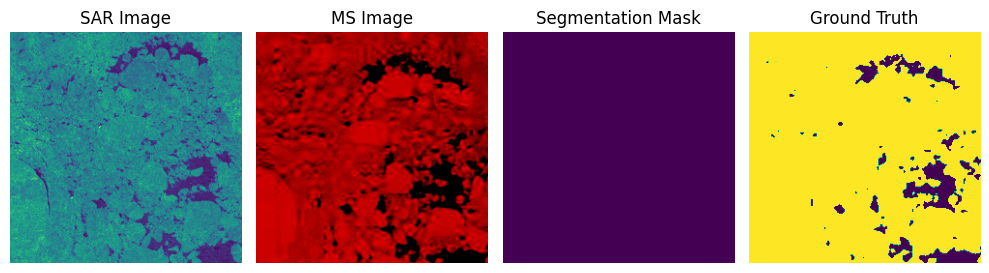

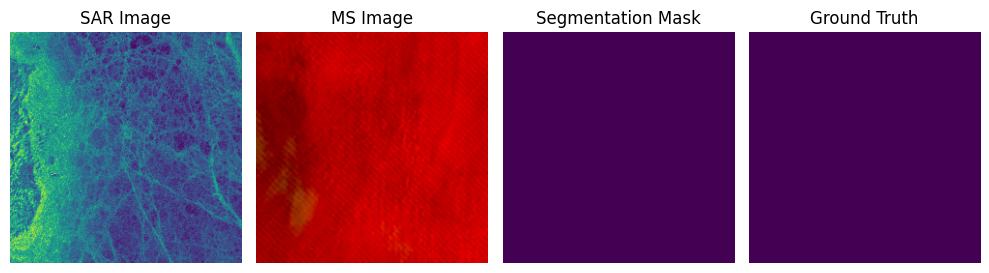

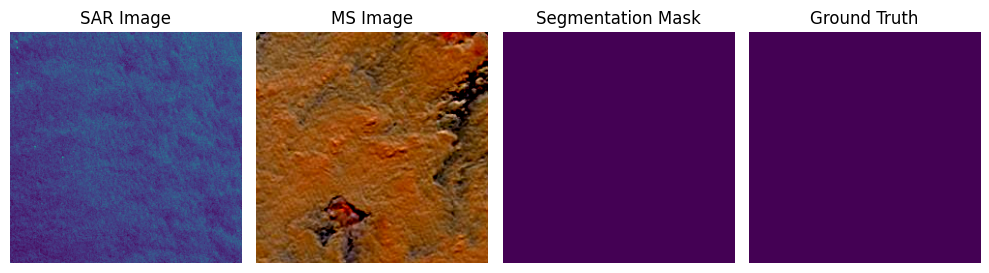

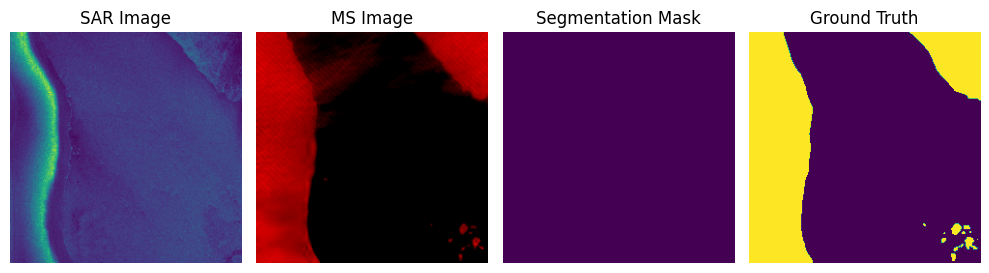

In [ ]:
preds = model.predict(val_generator,steps=1)

(X_sar_test, X_ms_test), y_test = next(iter(val_generator))

for i in range(preds.shape[0]):
    plt.figure(figsize=(10, 5))
    plt.subplot(141)
    plt.imshow(X_sar_test[i,:,:,:])
    plt.title('SAR Image')
    plt.axis('off')
    plt.subplot(142)
    plt.imshow(X_ms_test[i,:,:,:])
    plt.title('MS Image')
    plt.axis('off')
    plt.subplot(143)
    plt.imshow(preds[i,:,:,0]>threshold)
    plt.title('Segmentation Mask')
    plt.axis('off')
    plt.subplot(144)
    plt.imshow(y_test[i,:,:,0])
    plt.title('Ground Truth')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


<div style="background-color: #ccffcc; padding: 10px;">
    
* Are there any notable differences between the predicted segmentation mask and the ground truth?
* How does adjusting the threshold value impact the visualisation of the segmentation mask?
* Can you identify any challenging areas where the model struggles to accurately predict sea ice boundaries?
* What potential implications can accurate sea ice segmentation have on environmental research and decision-making processes?

<div style="background-color: #ccffcc; padding: 10px;">
    
# Generate Submission

Ta-da! 📝🎉 Our model is trained and ready, and it's time to run our
predictions on the test set and create the submission file.

A submission file named 'submission.csv' is created to store the predictions.
For each image in the test set, the image ID and run-length encoded pixels are written to the file.

In [ ]:
import pandas as pd

#ref:https://www.kaggle.com/paulorzp/run-length-encode-and-decode.
def rle_encode(mask):
    '''
    mask: numpy array binary mask
    1 - mask
    0 - background
    Returns encoded run length
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Predict on test data
predictions = model.predict(test_generator)

# Generate submission DataFrame
submission_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for i, patch_path in enumerate(test_patch_paths):
    image_id = os.path.basename(patch_path)
    mask = predictions[i, :, :, 0] > threshold
    encoded_pixels = rle_encode(mask)
    submission_df.loc[i] = [image_id, encoded_pixels]

# Save submission DataFrame to CSV file
submission_df.to_csv('submission.csv', index=False)

22/22 [==============================] - 5s 234ms/step


In [ ]:
#@title Click to download submission file

from google.colab import files
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Download csv", width=200, height=200)
output = widgets.Output()

def on_button_clicked(b):
    files.download('submission.csv')

button.on_click(on_button_clicked)
display(button, output)


Button(description='Download csv', style=ButtonStyle())

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div style="background-color: #ccffcc; padding: 10px;">
   
# Submitting your score    
    

In [ ]:
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        460           False  
https://www.kaggle.com/competitions/2023-kaggle-ai-report                                     2023-07-05 23:59:00  Analytics          $70,000        164           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       4106           False  
https://www.kaggle.com/competitions/hubmap-hacking-the-human-vasculature                      2023-07-31 23:59:00  Research           $50,000    

In [ ]:
!kaggle competitions files leeds-sciml-sea-ice-segmentation

name                                               size  creationDate         
------------------------------------------------  -----  -------------------  
sciml/test/Patch20190101_119_600_1560_sar.tiff      2MB  2023-06-06 15:37:04  
sciml/test/Patch20190101_150_840_240_sar.tiff       2MB  2023-06-06 15:37:04  
sciml/test/Patch20190101_114_600_960_sar.tiff       2MB  2023-06-06 15:37:04  
sciml/test/Patch20190101_141_720_1680_vis.tiff    675KB  2023-06-06 15:37:04  
sciml/test/Patch20190101_104_1814_960_sar.tiff      2MB  2023-06-06 15:37:04  
sciml/test/Patch20190101_141_720_1680_sar.tiff      2MB  2023-06-06 15:37:04  
sciml/test/Patch20190101_114_600_960_vis.tiff     675KB  2023-06-06 15:37:04  
sciml/test/Patch20190101_119_600_1560_vis.tiff    675KB  2023-06-06 15:37:04  
sciml/test/Patch20190101_115_600_1080_vis.tiff    675KB  2023-06-06 15:37:04  
sciml/test/Patch20190101_113_600_840_vis.tiff     675KB  2023-06-06 15:37:04  
sciml/test/Patch20190101_150_840_240_vis.tiff     67

In [ ]:
!kaggle competitions submit -c leeds-sciml-sea-ice-segmentation  -f submission.csv -m "Submission via API"

100% 9.55k/9.55k [00:01<00:00, 5.22kB/s]
Successfully submitted to Leeds SciML Sea Ice Segmentation

In [ ]:
!kaggle competitions submissions -c leeds-sciml-sea-ice-segmentation

fileName        date                 description         status    publicScore  privateScore  
--------------  -------------------  ------------------  --------  -----------  ------------  
submission.csv  2023-06-30 14:58:35  Submission via API  pending                              
submission.csv  2023-06-30 13:03:10  Submission via API  complete  0.78863                    


In [ ]:
!kaggle competitions  leaderboard leeds_sciml-sea-ice-segmentation --show